### You would need tensorflow v1.4 and above - ensure you have it

In [1]:
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras import Model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Bidirectional,Flatten,Dropout,Input,Conv1D, GlobalMaxPooling1D
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.merge import concatenate
from keras.preprocessing import text, sequence
from keras import utils
%matplotlib inline


Using TensorFlow backend.


### Data gathering

# Data was scraped using Using Kaggle's public dataset BigQuery integration.

##### The bigquery code used for data scraping. 
import bq_helper<br>
from bq_helper import BigQueryHelper<br>
from google.cloud import bigquery<br>
import pandas as pd<br>


stackOverflow = bq_helper.BigQueryHelper(active_project="bigquery-public-data",<br>
                                   dataset_name="stackoverflow")<br>
                                   
bq_assistant = BigQueryHelper("bigquery-public-data", "stackoverflow")<br>
bq_assistant.list_tables()<br>

query1 = """SELECT id, title, body as post, tags<br>
FROM `bigquery-public-data.stackoverflow.posts_questions`<br>
WHERE tags IN ("javascript", "java", "c#", "php", "android", "jquery", "python", "html", "c++", "ios", "css", "mysql", "sql", "asp.net", "ruby-on-rails", "objective-c", "c", ".net", "angularjs", "iphone")<br>
LIMIT 200000<br>
        """<br>

df.to_csv('Questions&Tags.csv',index=False)<br>


### Reading the data and seeing contents

In [2]:
os.chdir('/Users/Work/Desktop/Big Data')
df = pd.read_csv("Questions&Tags.csv",nrows=15000)
df.to_csv("Questions2.csv")

In [3]:
df.head()

,Unnamed: 0,id,title,post,tags
0,0,26111265,how to enable the click method after calling e...,"<pre><code>$('div.view-more').on('click', func...",jquery
1,1,954504,"How to get files in a directory, including all...",<p>I'm trying to get a list of all log files (...,python
2,2,2107283,how to submit a form and send fields that are ...,<p>I am trying to get a form like this:\n<a hr...,ruby-on-rails
3,3,27390370,Python: closest coordinate?,<p>I need help with a function that returns co...,python
4,4,39742887,communicate scope values between controllers i...,<ol>\n<li>using getters and setters in service...,angularjs


In [4]:
df['title']= df['title'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['title']=df['title'].str.replace('["\n\'?,]'," ")

In [5]:
df['title']=df['title'].str.replace('[^0-9a-zA-Z+#-.\s]','')

In [6]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['title'] = df['title'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [7]:
import regex as re
df['title'] = df['title'].str.replace('http\S+|www.\S+', '', case=False)

In [8]:
from textblob import Word
df['title'] = df['title'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [9]:
df.title.head()

0    enable click method calling e.preventdefault
1       get file directory including subdirectory
2                 submit form send field form tag
3                       python closest coordinate
4    communicate scope value controller angularjs
Name: title, dtype: object

In [10]:
#removing '<p>'
df['post']=df['post'].str.strip('<p>')
df['post']=df['post'].str.strip('</p>')
df['post']=df['post'].str.replace('$','')
df['post']= df['post'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['post']=df['post'].str.replace('["\n\'?,(,)]'," ")

In [11]:
df['post']=df['post'].str.replace('[^0-9a-zA-Z+#-.\s]','')

In [12]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['post'] = df['post'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [13]:
import regex as re
df['post'] = df['post'].str.replace('http\S+|www.\S+', '', case=False)

In [14]:
from textblob import Word
df['post'] = df['post'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [15]:
df.post.head()

0    recode div.view-more .on click function e e.pr...
1    trying get list log file .log directory includ...
2    trying get form like href rel nofollow norefer...
3    need help function return coordinate list coor...
4    ol liusing getters setter service later callin...
Name: post, dtype: object

In [16]:
df.tags.value_counts()

android          1889
javascript       1650
php              1500
java             1492
python           1455
c#               1043
jquery           1007
c++               932
mysql             895
c                 602
angularjs         465
ruby-on-rails     437
css               384
asp.net           291
sql               281
iphone            177
html              172
ios               167
objective-c       128
.net               33
Name: tags, dtype: int64

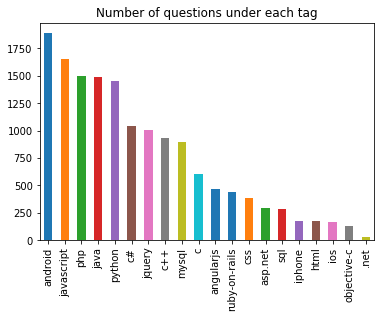

In [17]:
df['tags'].value_counts().sort_values(ascending=False).plot(kind='bar',title='Number of questions under each tag')

In [18]:
post = df.post.values
title=df.title.values
y =df.tags.values

### Splitting the data into train and test set

In [19]:
#train_posts, test_posts, train_tags, test_tags = train_test_split(post,y, test_size=.2)
#train_title,test_title, train_tags, test_tags = train_test_split(title,y, test_size=.2)


In [20]:
train_post = df.post[:12000]
test_post=df.post[12000:]
train_title = df.title[:12000]
test_title=df.title[12000:]


In [21]:
tags_train=df.tags[:12000]
tags_test=df.tags[12000:]


### Tokenizing the data using the keras tokenizer (using the top used 2000 words)

In [22]:
max_words = 2000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)


In [23]:
tokenize.fit_on_texts(df.post) # only fit on train
post_train = tokenize.texts_to_matrix(train_post)
post_test = tokenize.texts_to_matrix(test_post)

In [24]:
tokenize.fit_on_texts(df.title) # only fit on train
title_train = tokenize.texts_to_matrix(train_title)
title_test = tokenize.texts_to_matrix(test_title)

### Converting the labels to OneHotEncoded form ([0,1,0,0,0,0,0...0,0])

In [25]:
encoder = LabelBinarizer()
encoder.fit(tags_train)
y_train = encoder.transform(tags_train)
y_test = encoder.transform(tags_test)

In [26]:
num_classes = len(encoder.classes_)

### Printing the training and test input/output shapes

In [27]:
print('post_train shape:', post_train.shape)
print('post_test shape:', post_test.shape)
print('tags_train shape:', y_train.shape)
print('tags_test shape:', y_test.shape)

post_train shape: (12000, 2000)
post_test shape: (3000, 2000)
tags_train shape: (12000, 20)
tags_test shape: (3000, 20)


In [28]:
print('title_train shape:', title_train.shape)
print('title_test shape:', title_test.shape)
print('tags_train shape:', y_train.shape)
print('tags_test shape:', y_test.shape)

title_train shape: (12000, 2000)
title_test shape: (3000, 2000)
tags_train shape: (12000, 20)
tags_test shape: (3000, 20)


### Creating the model

In [29]:
#Setting the batch size and number of epochs
batch_size = 32
epochs = 5

### FCFW (post only) with embedding

In [30]:
model_post_emb = Sequential()
model_post_emb.add(Embedding(max_words, 100, input_length=post_train.shape[1]))
model_post_emb.add(SpatialDropout1D(0.7))
model_post_emb.add(Flatten())
model_post_emb.add(Dense(20, activation='softmax'))
model_post_emb.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### FCFW (title only) with embedding

In [31]:
model_title_emb = Sequential()
model_title_emb.add(Embedding(max_words, 100, input_length=title_train.shape[1]))
model_title_emb.add(SpatialDropout1D(0.7))
model_title_emb.add(Flatten())
model_title_emb.add(Dense(20, activation='softmax'))
model_title_emb.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### FCFW (Both) with embedding

In [32]:
model_both_post = Input(shape=(post_train.shape[1],))
A1=Embedding(max_words, 100)(model_both_post) 
A2=Dense(100, activation='relu')(A1)


model_both_title = Input(shape=(title_train.shape[1],))
B1=Embedding(max_words, 100)(model_both_title) 
B2=Dense(100, activation='relu')(B1)
combined1 = concatenate([model_both_post,model_both_title])
dense1=Dense(100, activation='relu')(combined1)
output1= Dense(20, activation='softmax')(dense1)


model_concat_emb=Model(inputs=[model_both_post,model_both_title],outputs=output1)


model_concat_emb.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

### FCFW (post only)

In [33]:
model_post_fcfw = Sequential()
model_post_fcfw.add(Dense(512, input_shape=(max_words,)))
model_post_fcfw.add(Activation('relu'))
model_post_fcfw.add(Dropout(0.5))
model_post_fcfw.add(Dense(num_classes))
model_post_fcfw.add(Activation('softmax'))

model_post_fcfw.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### FCFW (title only)

In [34]:
model_title_fcfw = Sequential()
model_title_fcfw.add(Dense(512, input_shape=(max_words,)))
model_title_fcfw.add(Activation('relu'))
model_title_fcfw.add(Dropout(0.5))
model_title_fcfw.add(Dense(num_classes))
model_title_fcfw.add(Activation('softmax'))

model_title_fcfw.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### FCFW with both columns

In [35]:
model_both_post_fcfw = Input(shape=(post_train.shape[1],)) 
A3=Dense(100, activation='relu')(model_both_post_fcfw)
model_both_title_fcfw = Input(shape=(title_train.shape[1],)) 
B3=Dense(100, activation='relu')(model_both_title_fcfw)
combined2 = concatenate([model_both_post_fcfw,model_both_title_fcfw])
dense2=Dense(100, activation='relu')(combined2)
output2= Dense(20, activation='softmax')(dense2)
model_concat_fcfw=Model(inputs=[model_both_post_fcfw,model_both_title_fcfw],outputs=output2)
model_concat_fcfw.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

### Training the models

In [89]:
history_post_emb=model_post_emb.fit(post_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 10800 samples, validate on 1200 samples
Epoch 1/5
10800/10800 [==============================] - 30s 3ms/step - loss: 1.5789 - acc: 0.5932 - val_loss: 0.7643 - val_acc: 0.7708
Epoch 2/5
10800/10800 [==============================] - 29s 3ms/step - loss: 0.5765 - acc: 0.8333 - val_loss: 0.7563 - val_acc: 0.7675
Epoch 3/5
10800/10800 [==============================] - 29s 3ms/step - loss: 0.3962 - acc: 0.8839 - val_loss: 0.8314 - val_acc: 0.7808
Epoch 4/5
10800/10800 [==============================] - 31s 3ms/step - loss: 0.3005 - acc: 0.9115 - val_loss: 0.9010 - val_acc: 0.7683
Epoch 5/5
10800/10800 [==============================] - 30s 3ms/step - loss: 0.2399 - acc: 0.9275 - val_loss: 0.9668 - val_acc: 0.7742


In [90]:
history_title_emb=model_title_emb.fit(title_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 10800 samples, validate on 1200 samples
Epoch 1/5
10800/10800 [==============================] - 33s 3ms/step - loss: 2.0699 - acc: 0.4404 - val_loss: 1.2685 - val_acc: 0.6125
Epoch 2/5
10800/10800 [==============================] - 33s 3ms/step - loss: 1.0764 - acc: 0.6695 - val_loss: 1.2368 - val_acc: 0.6350
Epoch 3/5
10800/10800 [==============================] - 30s 3ms/step - loss: 0.8941 - acc: 0.7208 - val_loss: 1.2998 - val_acc: 0.6375
Epoch 4/5
10800/10800 [==============================] - 30s 3ms/step - loss: 0.7944 - acc: 0.7495 - val_loss: 1.3933 - val_acc: 0.6267
Epoch 5/5
10800/10800 [==============================] - 30s 3ms/step - loss: 0.7323 - acc: 0.7631 - val_loss: 1.4637 - val_acc: 0.6292


In [36]:
history_concat_emb=model_concat_emb.fit([post_train,title_train], y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 10800 samples, validate on 1200 samples
Epoch 1/5
10800/10800 [==============================] - 3s 249us/step - loss: 1.1075 - acc: 0.7479 - val_loss: 0.5496 - val_acc: 0.8558
Epoch 2/5
10800/10800 [==============================] - 1s 133us/step - loss: 0.3314 - acc: 0.9196 - val_loss: 0.4652 - val_acc: 0.8633
Epoch 3/5
10800/10800 [==============================] - 1s 137us/step - loss: 0.1673 - acc: 0.9668 - val_loss: 0.4634 - val_acc: 0.8575
Epoch 4/5
10800/10800 [==============================] - 2s 160us/step - loss: 0.0880 - acc: 0.9877 - val_loss: 0.4719 - val_acc: 0.8575
Epoch 5/5
10800/10800 [==============================] - 1s 136us/step - loss: 0.0476 - acc: 0.9967 - val_loss: 0.4843 - val_acc: 0.8508


In [37]:
history_post_fcfw = model_post_fcfw.fit(post_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 10800 samples, validate on 1200 samples
Epoch 1/5
10800/10800 [==============================] - 5s 424us/step - loss: 1.2272 - acc: 0.6722 - val_loss: 0.7294 - val_acc: 0.7875
Epoch 2/5
10800/10800 [==============================] - 4s 409us/step - loss: 0.5347 - acc: 0.8449 - val_loss: 0.6609 - val_acc: 0.7917
Epoch 3/5
10800/10800 [==============================] - 4s 374us/step - loss: 0.3502 - acc: 0.8967 - val_loss: 0.6578 - val_acc: 0.8067
Epoch 4/5
10800/10800 [==============================] - 4s 378us/step - loss: 0.2427 - acc: 0.9329 - val_loss: 0.6864 - val_acc: 0.7967
Epoch 5/5
10800/10800 [==============================] - 4s 368us/step - loss: 0.1730 - acc: 0.9578 - val_loss: 0.7341 - val_acc: 0.7875


In [38]:
history_title_fcfw=model_title_fcfw.fit(title_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 10800 samples, validate on 1200 samples
Epoch 1/5
10800/10800 [==============================] - 4s 400us/step - loss: 1.7589 - acc: 0.5277 - val_loss: 1.2600 - val_acc: 0.6258
Epoch 2/5
10800/10800 [==============================] - 4s 365us/step - loss: 1.0158 - acc: 0.6892 - val_loss: 1.1498 - val_acc: 0.6483
Epoch 3/5
10800/10800 [==============================] - 4s 382us/step - loss: 0.8274 - acc: 0.7391 - val_loss: 1.1634 - val_acc: 0.6517
Epoch 4/5
10800/10800 [==============================] - 4s 383us/step - loss: 0.7091 - acc: 0.7723 - val_loss: 1.1932 - val_acc: 0.6458
Epoch 5/5
10800/10800 [==============================] - 4s 369us/step - loss: 0.6312 - acc: 0.7950 - val_loss: 1.2408 - val_acc: 0.6450


In [39]:
history_concat_fcfw = model_concat_fcfw.fit([post_train,title_train], y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 10800 samples, validate on 1200 samples
Epoch 1/5
10800/10800 [==============================] - 2s 162us/step - loss: 1.0999 - acc: 0.7464 - val_loss: 0.5570 - val_acc: 0.8500
Epoch 2/5
10800/10800 [==============================] - 1s 137us/step - loss: 0.3286 - acc: 0.9213 - val_loss: 0.4773 - val_acc: 0.8467
Epoch 3/5
10800/10800 [==============================] - 1s 137us/step - loss: 0.1675 - acc: 0.9669 - val_loss: 0.4506 - val_acc: 0.8517
Epoch 4/5
10800/10800 [==============================] - 2s 166us/step - loss: 0.0869 - acc: 0.9886 - val_loss: 0.4666 - val_acc: 0.8567
Epoch 5/5
10800/10800 [==============================] - 2s 147us/step - loss: 0.0467 - acc: 0.9963 - val_loss: 0.4821 - val_acc: 0.8558


### Evaluating on the test set

In [95]:
score_post_emb = model_post_emb.evaluate(post_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score_post_emb[0])
print('Test accuracy:', score_post_emb[1]*100)

3000/3000 [==============================] - 1s 488us/step
Test score: 1.0685610249837239
Test accuracy: 76.63333333333333


In [96]:
score_title_emb = model_title_emb.evaluate(title_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score_title_emb[0])
print('Test accuracy:', score_title_emb[1]*100)

3000/3000 [==============================] - 1s 472us/step
Test score: 1.428955021540324
Test accuracy: 62.96666667461396


In [40]:
score_emb_both = model_concat_emb.evaluate([post_test,title_test], y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score_emb_both[0])
print('Test accuracy:', score_emb_both[1]*100)

3000/3000 [==============================] - 0s 119us/step
Test score: 0.5224396087328593
Test accuracy: 84.7666666507721


In [41]:
score_post_fcfw = model_post_fcfw.evaluate(post_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score_post_fcfw[0])
print('Test accuracy:', score_post_fcfw[1]*100)

3000/3000 [==============================] - 0s 87us/step
Test score: 0.7390867972373962
Test accuracy: 79.60000000000001


In [42]:
score_title_fcfw = model_title_fcfw.evaluate(title_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score_title_fcfw[0])
print('Test accuracy:', score_title_fcfw[1]*100)

3000/3000 [==============================] - 0s 72us/step
Test score: 1.1948782749176026
Test accuracy: 65.26666666666667


In [43]:
score_fcfw_both = model_concat_fcfw.evaluate([post_test,title_test], y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score_fcfw_both[0])
print('Test accuracy:', score_fcfw_both[1]*100)

3000/3000 [==============================] - 0s 50us/step
Test score: 0.5166552578608195
Test accuracy: 85.23333331743876


## Of all our models, the feed forward network with both the title and post columns seems to have the highest accuracy of ~85.33% Not bad for a set with 20 classes! Much better then a random guess probability of 5%

### Sample predictions

In [44]:
tags_test=np.array(tags_test)
x_test_title=np.array(title_test)
x_test_post=np.array(post_test)
test_post=np.array(test_post)
test_title=np.array(test_title)

In [46]:
text_labels = encoder.classes_ 
for i in range(10):
    pred=model_post_fcfw.predict([x_test_post])
    print(test_title[i][:50],"...")
    print(test_post[i][:50],"...")
    print('Actual label:'+tags_test[i])
    print("Predicted label:"+text_labels[np.argmax(pred[i])]+"\n")

asp.net listview search & edit working ...
got asp.net listview search function. retrieving s ...
Actual label:asp.net
Predicted label:asp.net

map search numberformat exception android platform ...
friend implemented map search option application r ...
Actual label:android
Predicted label:android

boolean field java model class better use boolean  ...
boolean field java model class better use boolean  ...
Actual label:java
Predicted label:java

mysql join query problem ...
tablesp pproductp precodepid name 1 aa 2 bb 3 cc c ...
Actual label:mysql
Predicted label:mysql

rake generatesessionstore error gemfile ...
trying make site live hostgator following href rel ...
Actual label:ruby-on-rails
Predicted label:ruby-on-rails

javascript fabric.js draw line cycle ...
drawing one line. want draw grid.p hr pdiv class s ...
Actual label:javascript
Predicted label:javascript

python import modul whose value given string ...
beginner question. p pi code error messagep precod ...
Actual label:py

In [54]:
text_labels = encoder.classes_ 

for i in range(50):
    pred=model_concat_fcfw.predict([x_test_post,x_test_title])
    print(test_title[i][:50],"...")
    print(test_post[i][:50],"...")
    print('Actual label:'+tags_test[i])
    print("Predicted label:"+text_labels[np.argmax(pred[i])]+"\n")
    
    



asp.net listview search & edit working ...
got asp.net listview search function. retrieving s ...
Actual label:asp.net
Predicted label:asp.net

map search numberformat exception android platform ...
friend implemented map search option application r ...
Actual label:android
Predicted label:android

boolean field java model class better use boolean  ...
boolean field java model class better use boolean  ...
Actual label:java
Predicted label:java

mysql join query problem ...
tablesp pproductp precodepid name 1 aa 2 bb 3 cc c ...
Actual label:mysql
Predicted label:mysql

rake generatesessionstore error gemfile ...
trying make site live hostgator following href rel ...
Actual label:ruby-on-rails
Predicted label:ruby-on-rails

javascript fabric.js draw line cycle ...
drawing one line. want draw grid.p hr pdiv class s ...
Actual label:javascript
Predicted label:javascript

python import modul whose value given string ...
beginner question. p pi code error messagep precod ...
Actual label:py

In [55]:
y_softmax = model_concat_fcfw.predict([x_test_post,x_test_title])

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

### Generate classification report

In [56]:
print(classification_report(y_test_1d, y_pred_1d, target_names=encoder.classes_))

               precision    recall  f1-score   support

         .net       0.00      0.00      0.00         7
      android       0.91      0.92      0.92       369
    angularjs       1.00      0.90      0.95        79
      asp.net       0.80      0.77      0.79        71
            c       0.80      0.81      0.81       116
           c#       0.77      0.72      0.75       228
          c++       0.75      0.81      0.78       174
          css       0.85      0.90      0.87        79
         html       0.69      0.35      0.47        31
          ios       0.67      0.56      0.61        32
       iphone       0.69      0.61      0.65        33
         java       0.83      0.89      0.86       289
   javascript       0.84      0.86      0.85       327
       jquery       0.85      0.89      0.87       194
        mysql       0.85      0.85      0.85       186
  objective-c       0.60      0.41      0.49        22
          php       0.90      0.90      0.90       302
       py

### Generate confusion matrix acoss data - this code is from the scikit-learn help pages

In [57]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

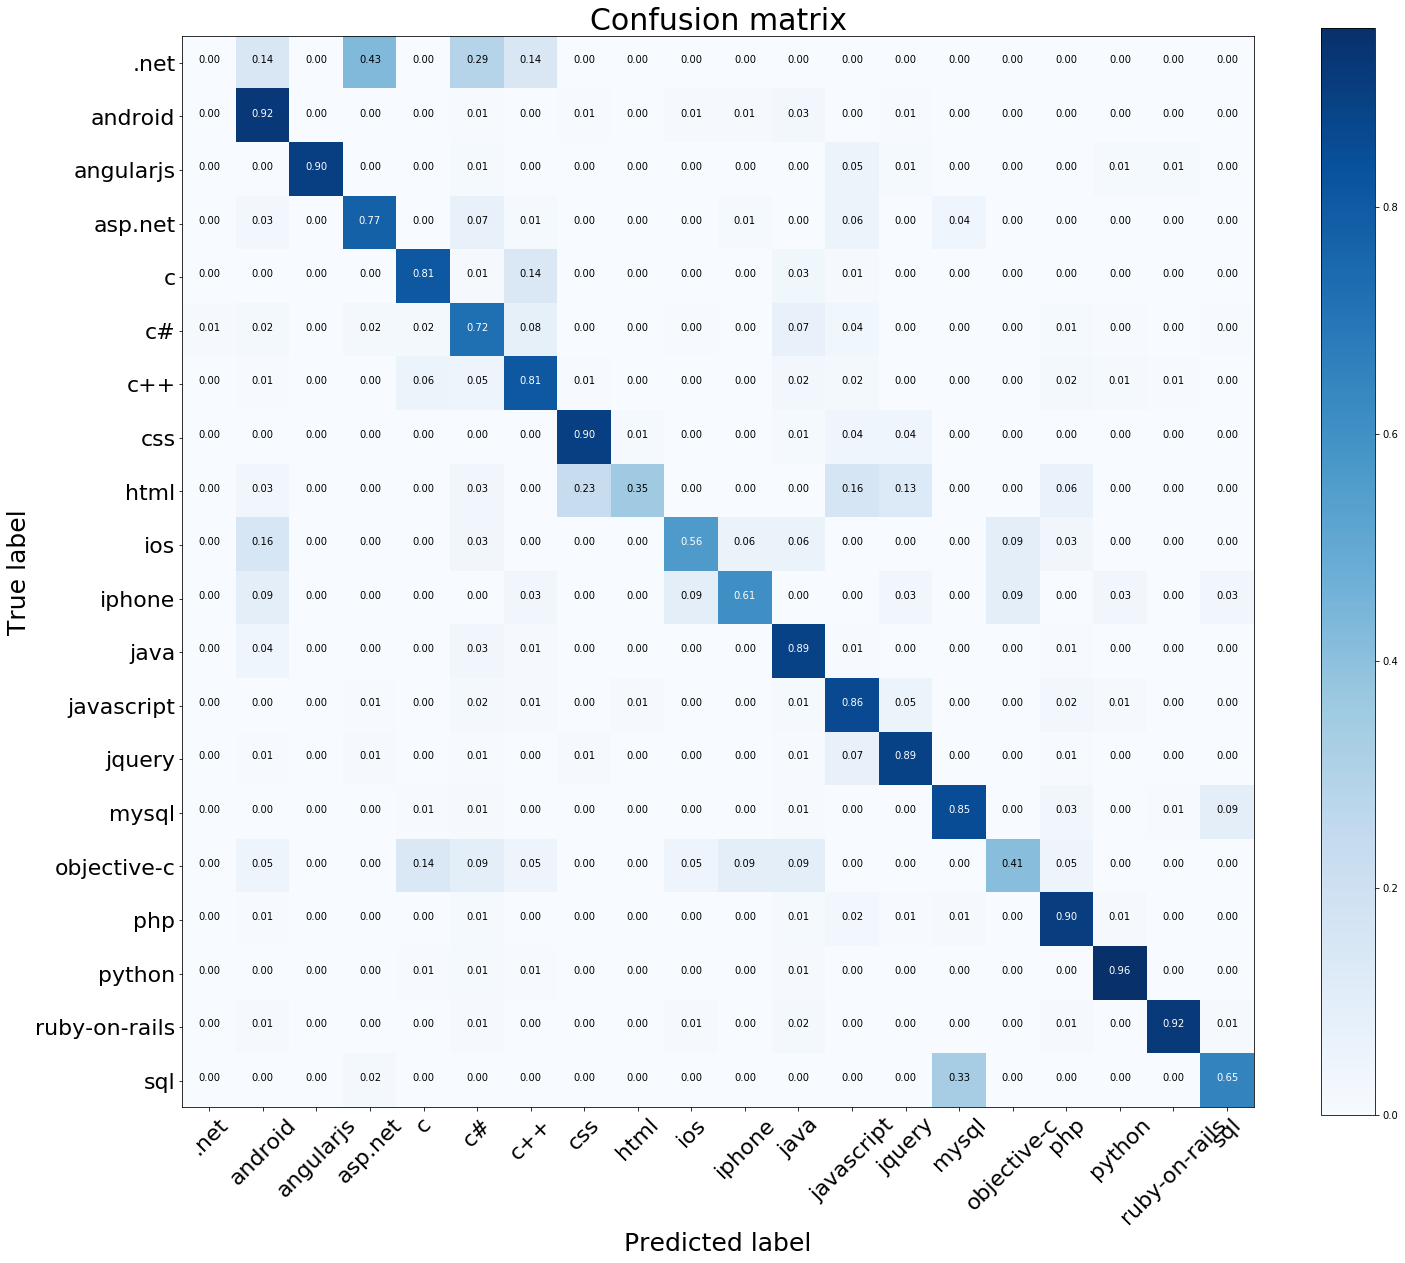

In [58]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()